In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import random
import einops

from typing import Dict, List, Tuple
from torch import Tensor
from jaxtyping import Float, Int
from transformer_lens import HookedTransformer

/net/scratch2/arditi/repos/iclr/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/net/scratch2/arditi/repos/iclr/.venv/lib/python3.10/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
torch.set_grad_enabled(False)

In [3]:
def set_seed(seed: int):
    torch.random.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

In [4]:
model = HookedTransformer.from_pretrained_no_processing('meta-llama/Llama-3.1-8B', device='cuda')

Loading checkpoint shards: 100%|██████████| 4/4 [00:15<00:00,  3.82s/it]


Loaded pretrained model meta-llama/Llama-3.1-8B into HookedTransformer


In [5]:

class Grid:
    def __init__(self, words, rows, cols):
        n_words = len(words)
        
        if rows * cols != n_words:
            raise ValueError(f"Grid dimensions ({rows}x{cols}={rows*cols}) do not match number of words ({n_words})")

        self.words = words
        self.rows = rows
        self.cols = cols
        self.grid = np.array(words).reshape(self.rows, self.cols).tolist()

        self.word_to_col = {word: i % cols for i, word in enumerate(words)}
        self.word_to_row = {word: i // cols for i, word in enumerate(words)}

    def generate_sequence(self, seq_len):
        sequence = []

        row, col = np.random.randint(0, self.rows), np.random.randint(0, self.cols)
        sequence.append(self.grid[row][col])

        while len(sequence) < seq_len:
            valid_moves = self._get_valid_moves(row, col)

            direction = np.random.choice(valid_moves)
            if direction == 'up':
                row -= 1
            elif direction == 'down':
                row += 1
            elif direction == 'left':
                col -= 1
            elif direction == 'right':
                col += 1

            sequence.append(self.grid[row][col])

        return sequence
    
    def get_valid_next_words(self, word):
        row, col = self.word_to_row[word], self.word_to_col[word]
        return self._get_valid_next_words_from_position(row, col)
    
    def _get_valid_next_words_from_position(self, row, col):
        valid_moves = self._get_valid_moves(row, col)
        next_words = []
        for move in valid_moves:
            if move == 'up':
                next_words.append(self.grid[row-1][col])
            elif move == 'down':
                next_words.append(self.grid[row+1][col])
            elif move == 'left':
                next_words.append(self.grid[row][col-1])
            elif move == 'right':
                next_words.append(self.grid[row][col+1])
        return next_words
    
    def _get_valid_moves(self, row, col):
        valid_moves = []
        if row > 0: valid_moves.append('up')
        if row < self.rows - 1: valid_moves.append('down')
        if col > 0: valid_moves.append('left')
        if col < self.cols - 1: valid_moves.append('right')
        return valid_moves

In [6]:
words = ['apple', 'bird', 'car', 'egg','house', 'milk', 'plane', 'opera', 'box', 'sand', 'sun', 'mango', 'rock', 'math', 'code', 'phone']

In [7]:
grid = Grid(words, rows=4, cols=4)

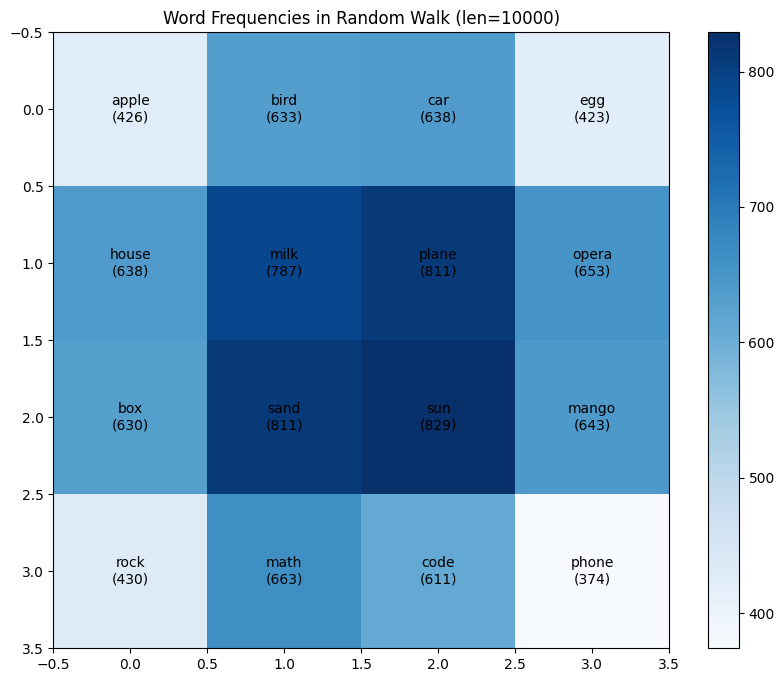

In [8]:
N_STEPS = 10_000

sequence = grid.generate_sequence(N_STEPS)

# histogram of word frequencies:
word_freq = {}
for word in sequence:
    if word in word_freq:
        word_freq[word] += 1
    else:
        word_freq[word] = 1

# Create a 2D array of frequencies matching the grid layout
freq_grid = np.zeros((grid.rows, grid.cols))
for i, row in enumerate(grid.grid):
    for j, word in enumerate(row):
        freq_grid[i][j] = word_freq.get(word, 0)

# Plot the heatmap
plt.figure(figsize=(10, 8))
plt.imshow(freq_grid, cmap='Blues', interpolation='nearest')
plt.colorbar()

# Add word labels to each cell
for i in range(grid.rows):
    for j in range(grid.cols):
        plt.text(j, i, f'{grid.grid[i][j]}\n({int(freq_grid[i][j])})', 
                ha='center', va='center')
        

plt.title(f'Word Frequencies in Random Walk (len={N_STEPS})')
plt.show()


In [9]:
def tokenize_sequence(sequence: list[str]) -> torch.Tensor:
    sequence_as_string = ' ' + ' '.join(sequence)
    return model.tokenizer(sequence_as_string, return_tensors='pt').input_ids

In [10]:
sequence = grid.generate_sequence(10)

tokens = tokenize_sequence(sequence)
model.to_str_tokens(tokens)

['<|begin_of_text|>',
 ' house',
 ' apple',
 ' bird',
 ' milk',
 ' sand',
 ' box',
 ' rock',
 ' math',
 ' sand',
 ' sun']

## Give it to the model

In [11]:
def get_model_accuracies(sequence: list[str]):
    tokens = tokenize_sequence(sequence)
    logits = model(tokens.to(model.cfg.device))
    probs = torch.softmax(logits, dim=-1)
    probs = probs[0, 1:, :] # shave off bos token

    accuracies = []

    for i in range(len(sequence)):
        valid_next_words = grid.get_valid_next_words(sequence[i])
        valid_next_word_token_ids = torch.tensor([model.tokenizer.encode(' ' + w, add_special_tokens=False) for w in valid_next_words]).squeeze()
        accuracy = probs[i, valid_next_word_token_ids].sum().item()
        accuracies.append(accuracy)

    return accuracies

In [13]:
SEQ_LEN = 1400
ITERS = 20
SEED = 0

set_seed(SEED)
accuracies = []

for iterations in tqdm.tqdm(range(ITERS)):
    accuracies.append(get_model_accuracies(grid.generate_sequence(SEQ_LEN)))

100%|██████████| 20/20 [00:34<00:00,  1.73s/it]


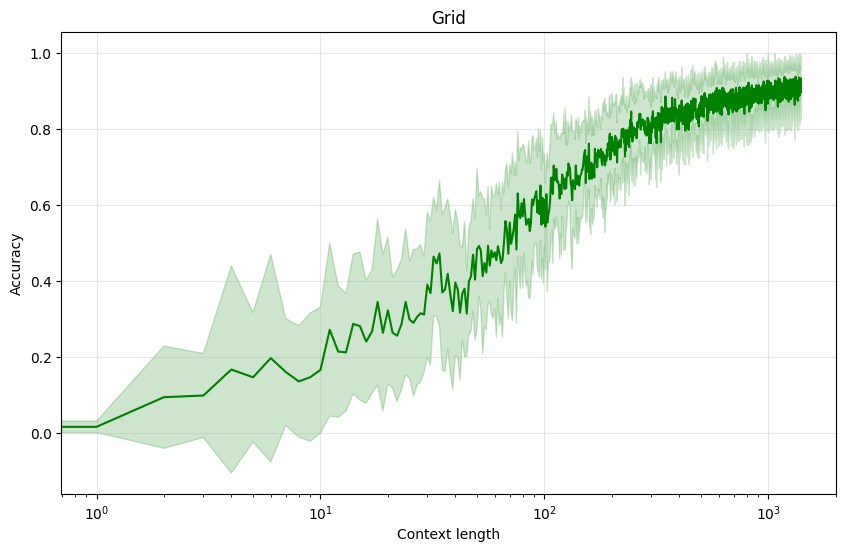

In [14]:
accuracies = np.array(accuracies)
mean = accuracies.mean(axis=0)
std = accuracies.std(axis=0)

plt.figure(figsize=(10, 6))
plt.plot(mean, label='Mean accuracy', color='green')
plt.fill_between(
    range(len(mean)), 
    mean - std, 
    mean + std, 
    alpha=0.2,
    color='green'
)

plt.xscale('log')
plt.xlabel('Context length')
plt.ylabel('Accuracy')
plt.title('Grid')
plt.grid(True, alpha=0.3)
plt.show()

## Analyze representations

In [15]:
def get_activations(sequence: list[str], n_lookback: int, layers: list[int], mean_centered: bool = True):
    tokens = tokenize_sequence(sequence)
    names_filter = [f'blocks.{layer}.hook_resid_pre' for layer in layers]
    _, cache = model.run_with_cache(tokens.to(model.cfg.device), names_filter=names_filter)

    layer_to_acts = {}

    for layer in layers:
        cache_key = f'blocks.{layer}.hook_resid_pre'
        layer_to_acts[layer] = cache[cache_key][0, -n_lookback:, :]

    if mean_centered:
        layer_to_acts = {layer: acts - acts.mean(dim=0, keepdim=True) for layer, acts in layer_to_acts.items()}
    
    return layer_to_acts

def get_pca_directions(acts: Float[Tensor, "ctx d_model"], top_n: int = 2):
    acts_centered = acts - acts.mean(dim=0, keepdim=True)
    _, _, V = torch.svd(acts_centered)
    return einops.rearrange(V, 'd_model n -> n d_model')[:top_n, :]

In [16]:
def visualize_pca(
    sequence: list[str],
    acts: torch.Tensor,
    pca_directions: torch.Tensor,
    n_lookback: int,
    plot_title: str,
):
    plt.figure(figsize=(12, 8))

    # Define distinct colors for words
    distinct_colors = {
        word: color for word, color in zip(grid.words, [
            '#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', 
            '#ffff33', '#a65628', '#f781bf', '#999999', '#66c2a5', 
            '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f', '#e5c494'
        ])
    }

    # Project activations
    projected = acts @ pca_directions.T
    
    # Get word-averaged positions
    word_to_avg_pos = {}
    for word in grid.words:
        word_indices = [i for i, w in enumerate(sequence[-n_lookback:]) if w == word]
        if word_indices:  # only if we have instances of this word
            word_points = projected[word_indices]
            word_to_avg_pos[word] = word_points.mean(dim=0).cpu()

    # Draw grid connections
    for word in word_to_avg_pos:
        connected_words = grid.get_valid_next_words(word)
        start_pos = word_to_avg_pos[word]
        for next_word in connected_words:
            if next_word in word_to_avg_pos:
                end_pos = word_to_avg_pos[next_word]
                plt.plot([start_pos[0], end_pos[0]], 
                        [start_pos[1], end_pos[1]], 
                        color='gray', alpha=0.3, linestyle='--')

    # Plot points and averages
    for word in word_to_avg_pos:
        word_indices = [i for i, w in enumerate(sequence[-n_lookback:]) if w == word]
        word_points = projected[word_indices]
        
        # Plot individual points
        plt.scatter(word_points[:, 0].cpu(), 
                   word_points[:, 1].cpu(), 
                   color=distinct_colors[word],
                   alpha=0.4,
                   s=30)
        
        # Plot and annotate average
        avg_point = word_to_avg_pos[word]
        plt.scatter(avg_point[0], 
                   avg_point[1], 
                   color=distinct_colors[word],
                   s=200,
                   marker='*',
                   edgecolors='black',
                   linewidth=1.5)
        
        plt.annotate(word, 
                    (avg_point[0], avg_point[1]),
                    xytext=(5, 5),
                    textcoords='offset points',
                    fontsize=8,
                    bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

    plt.title(plot_title)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

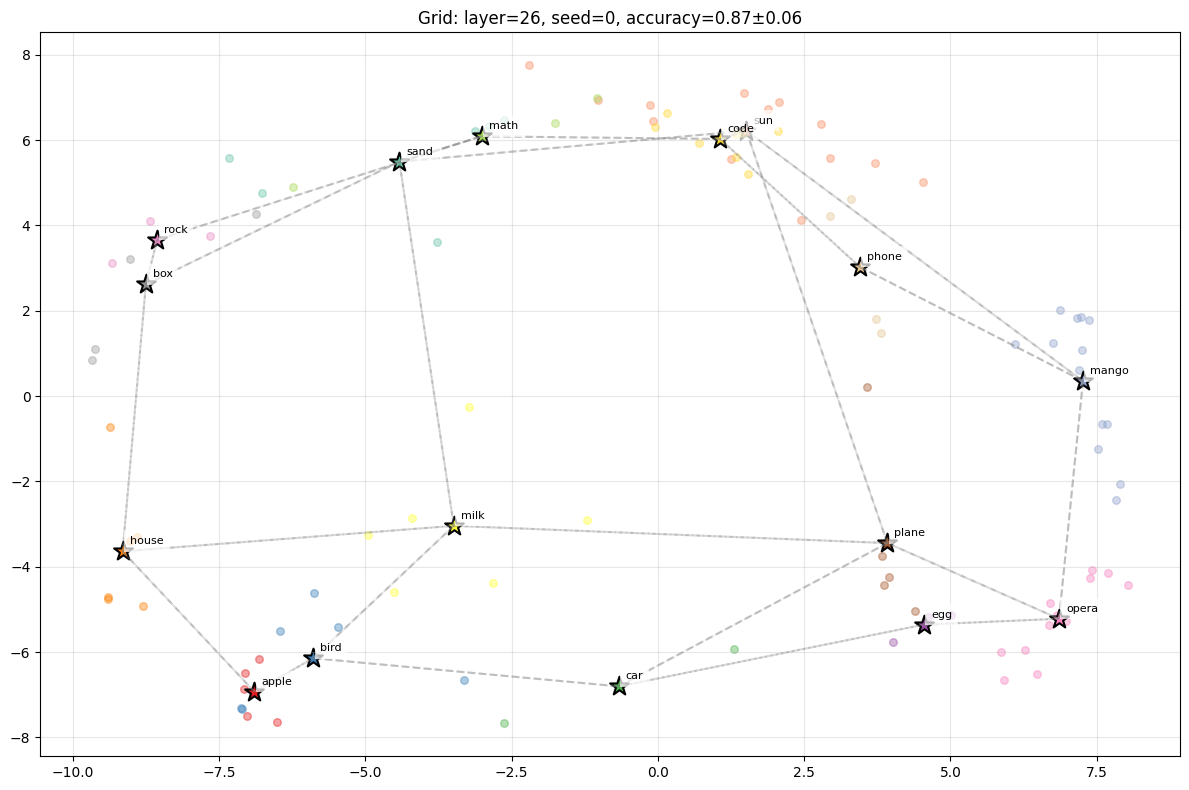

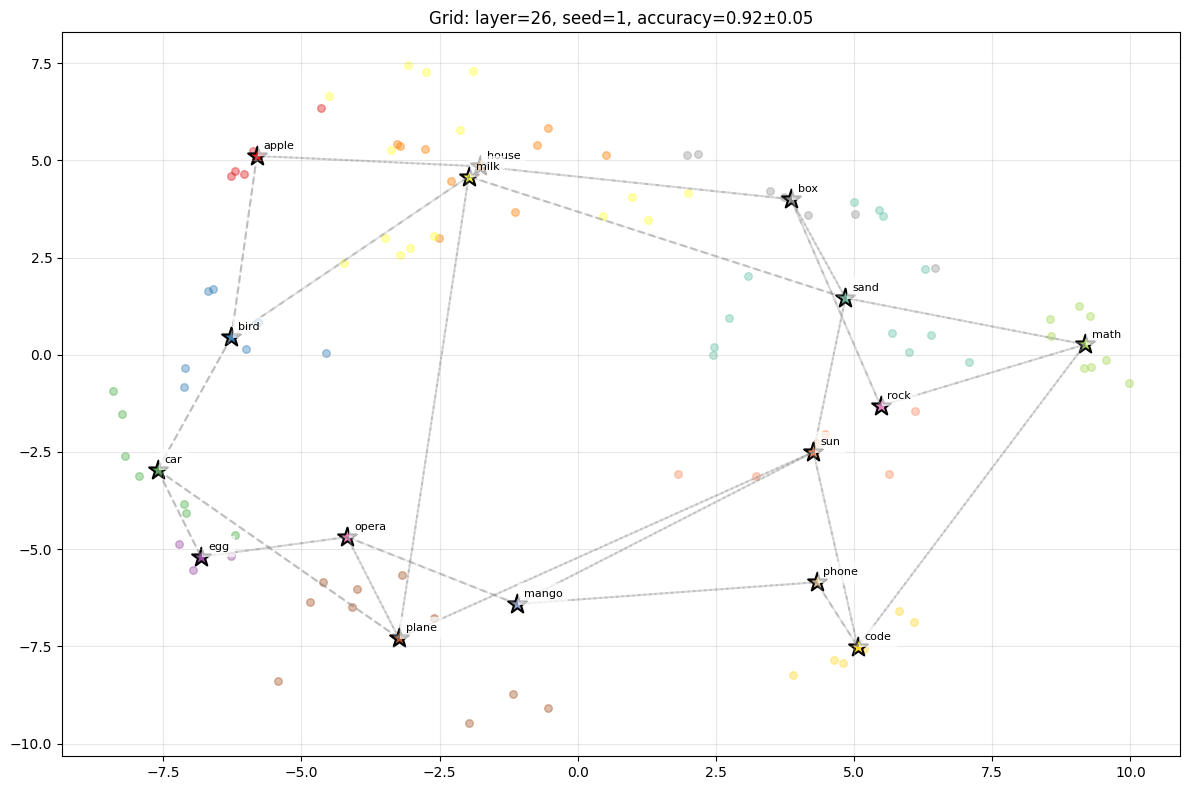

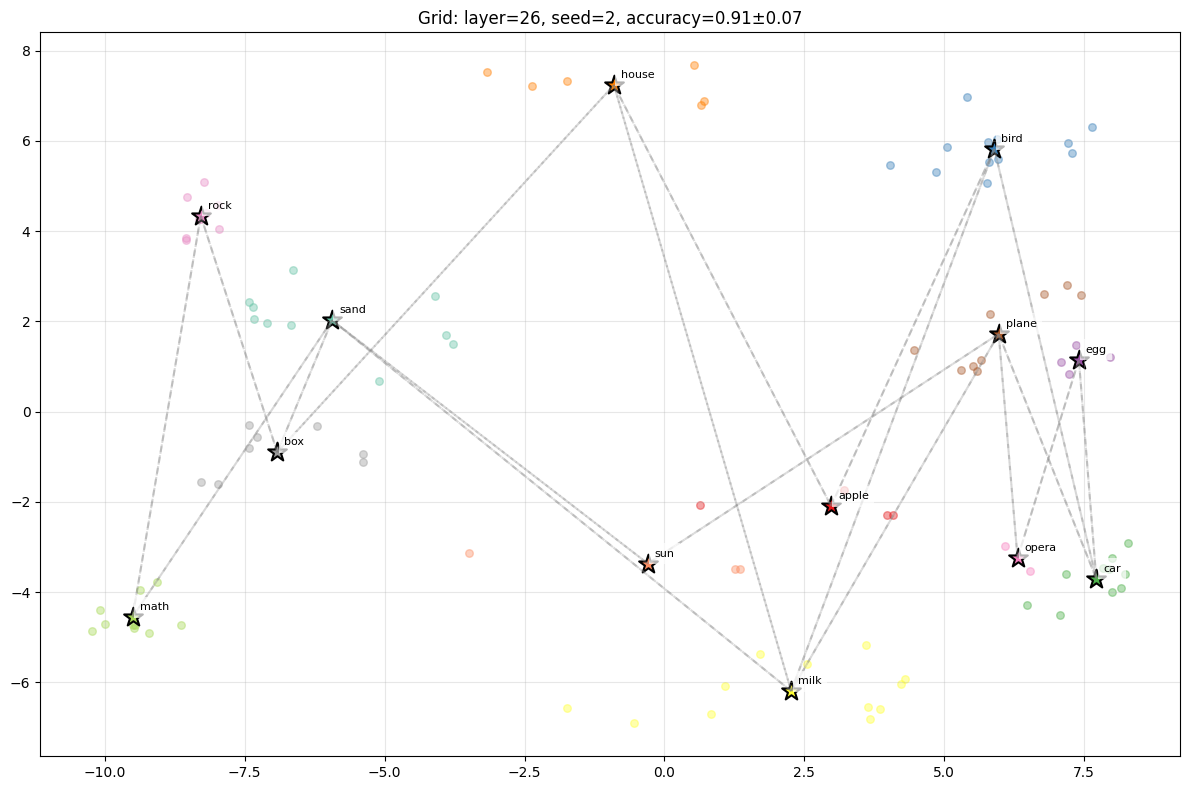

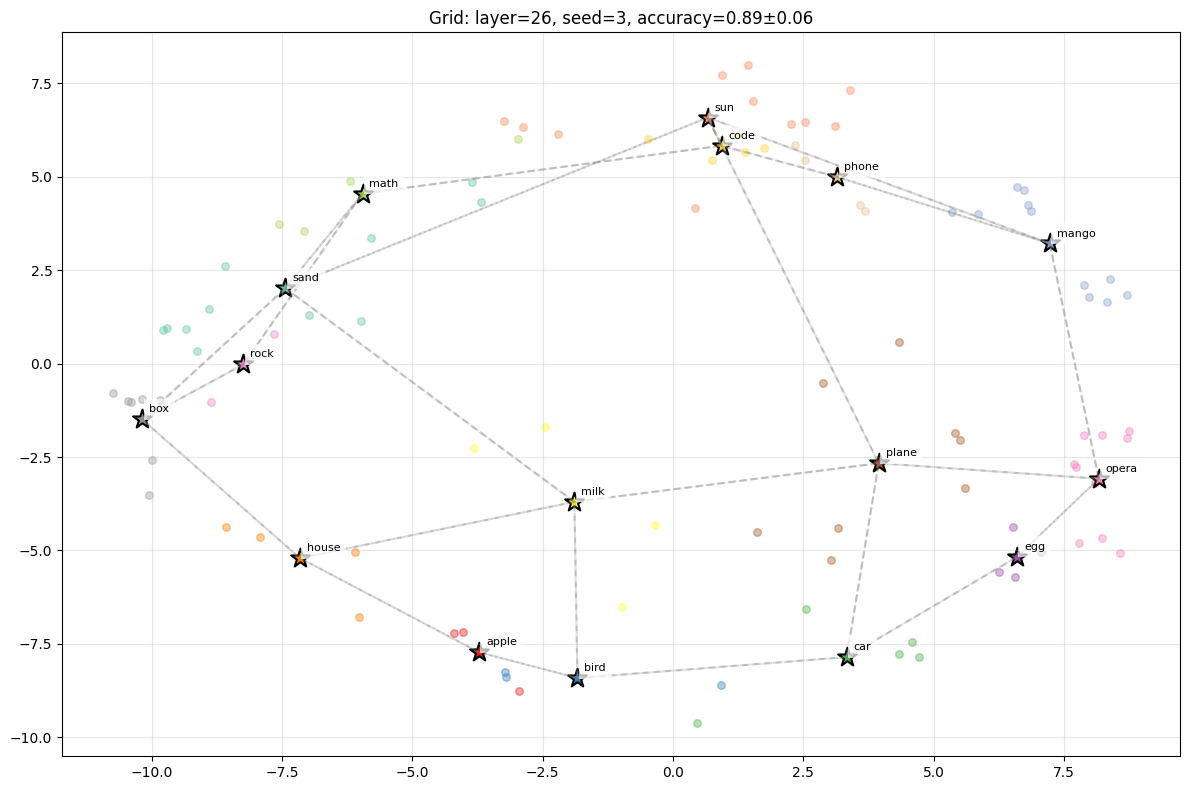

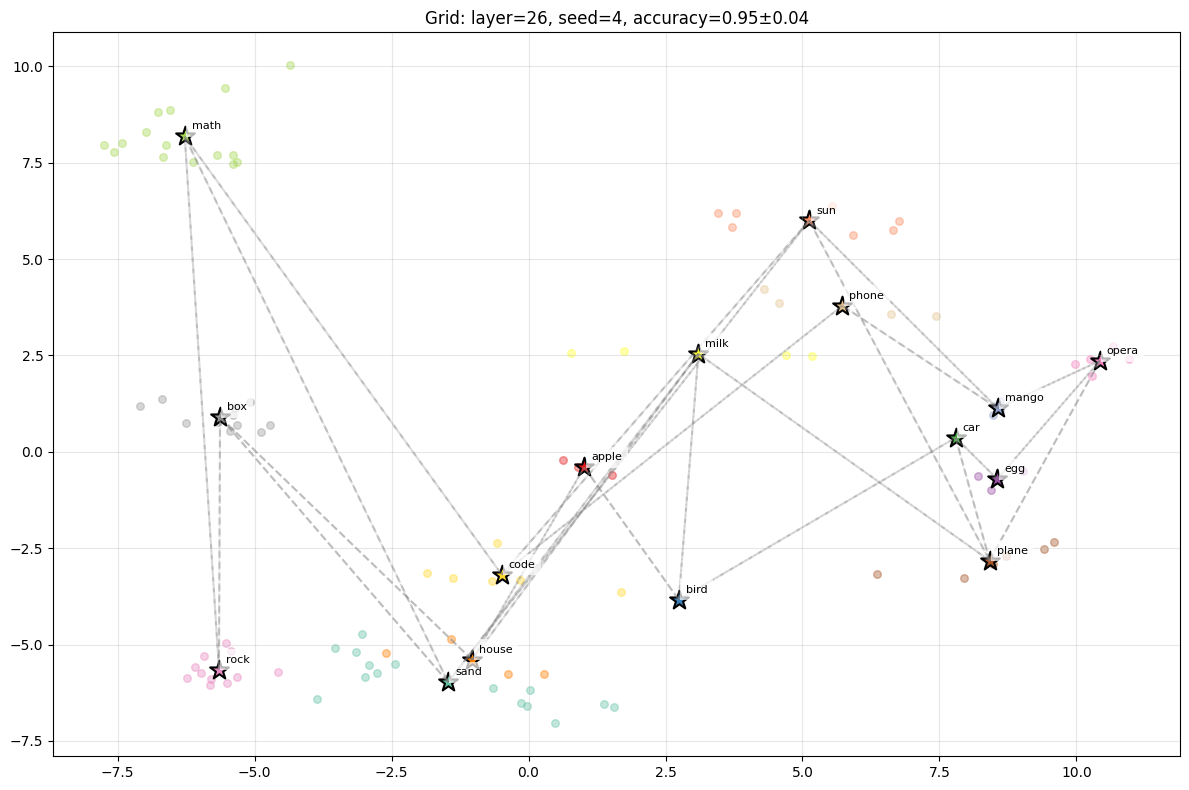

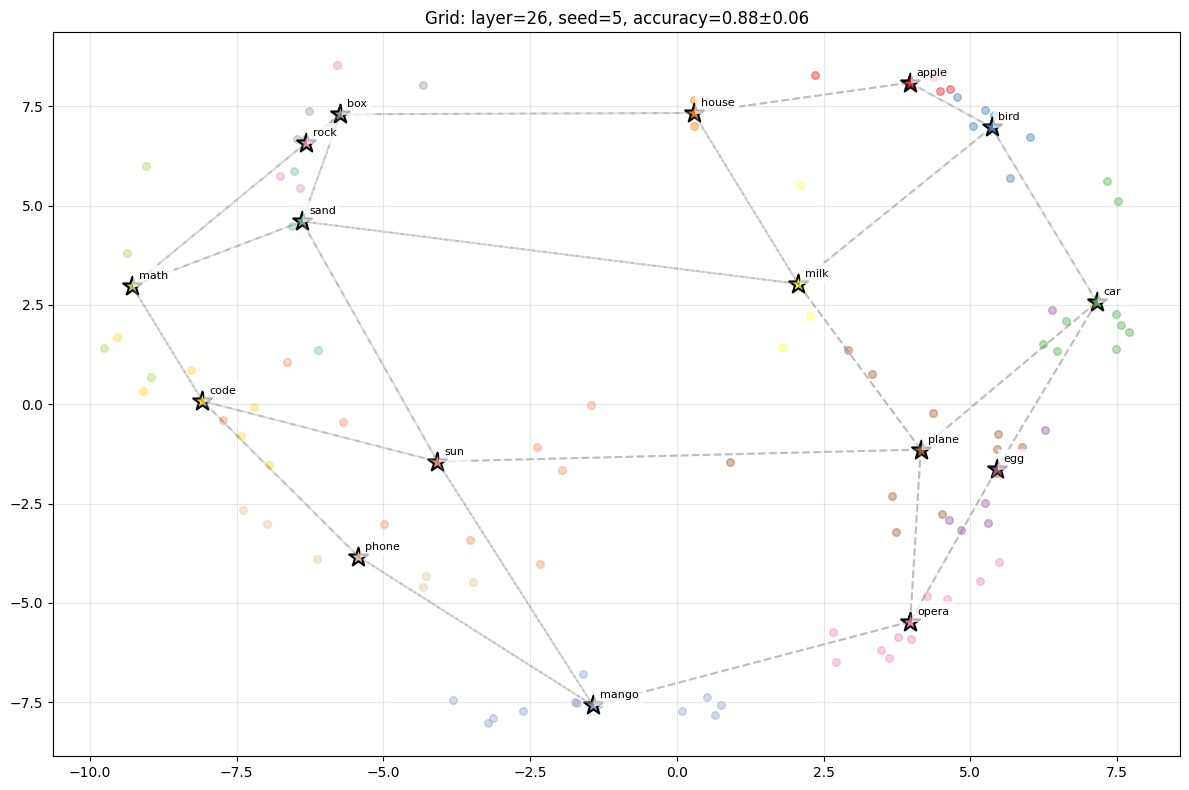

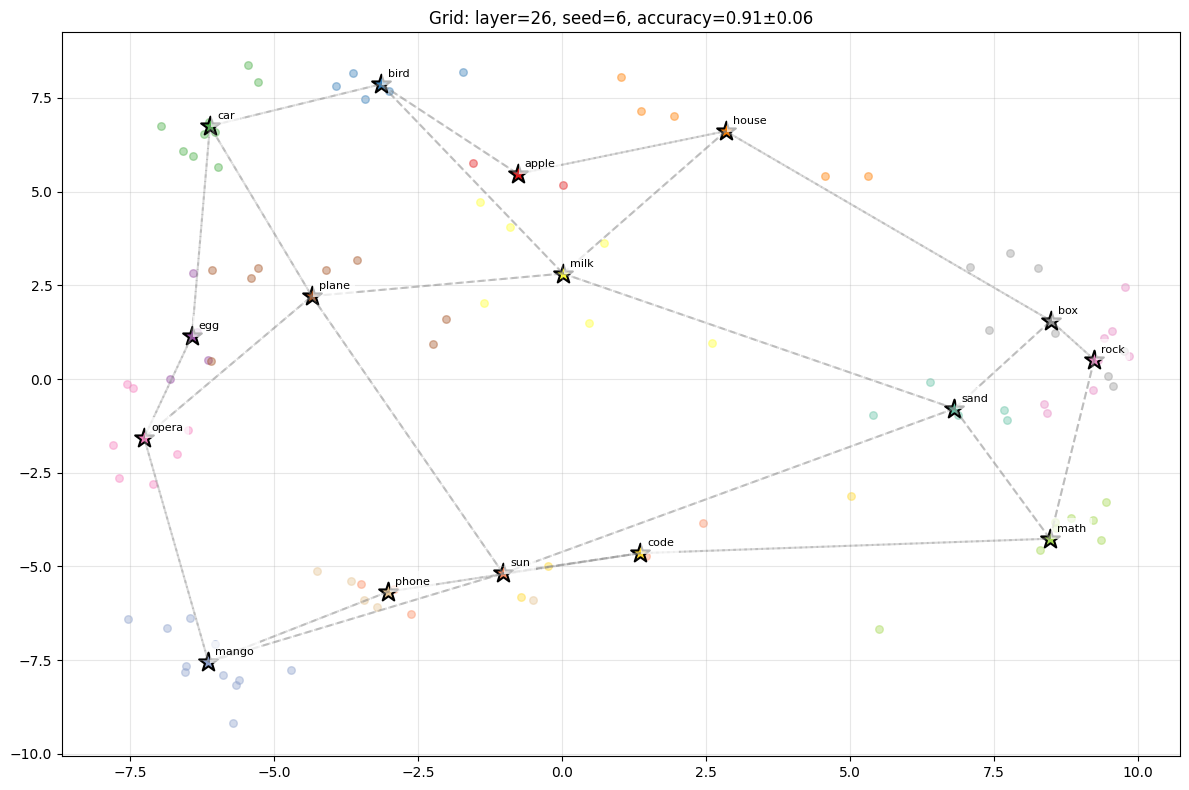

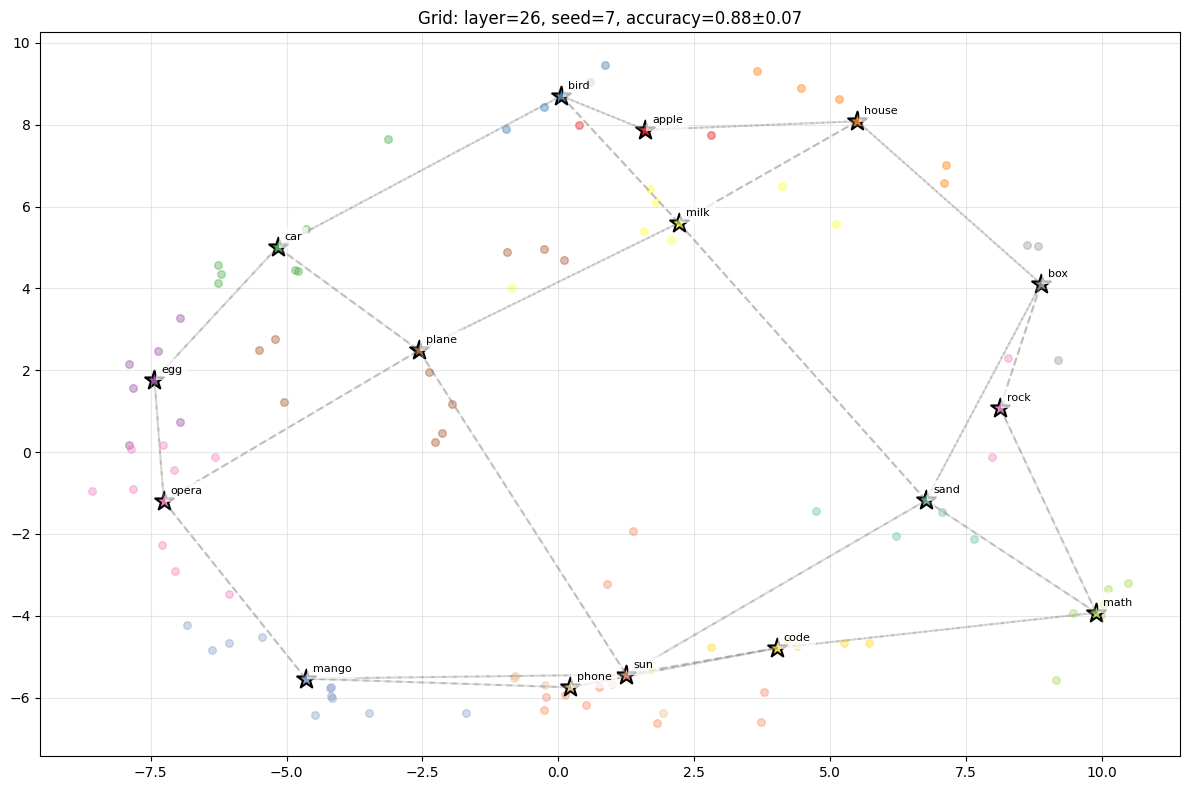

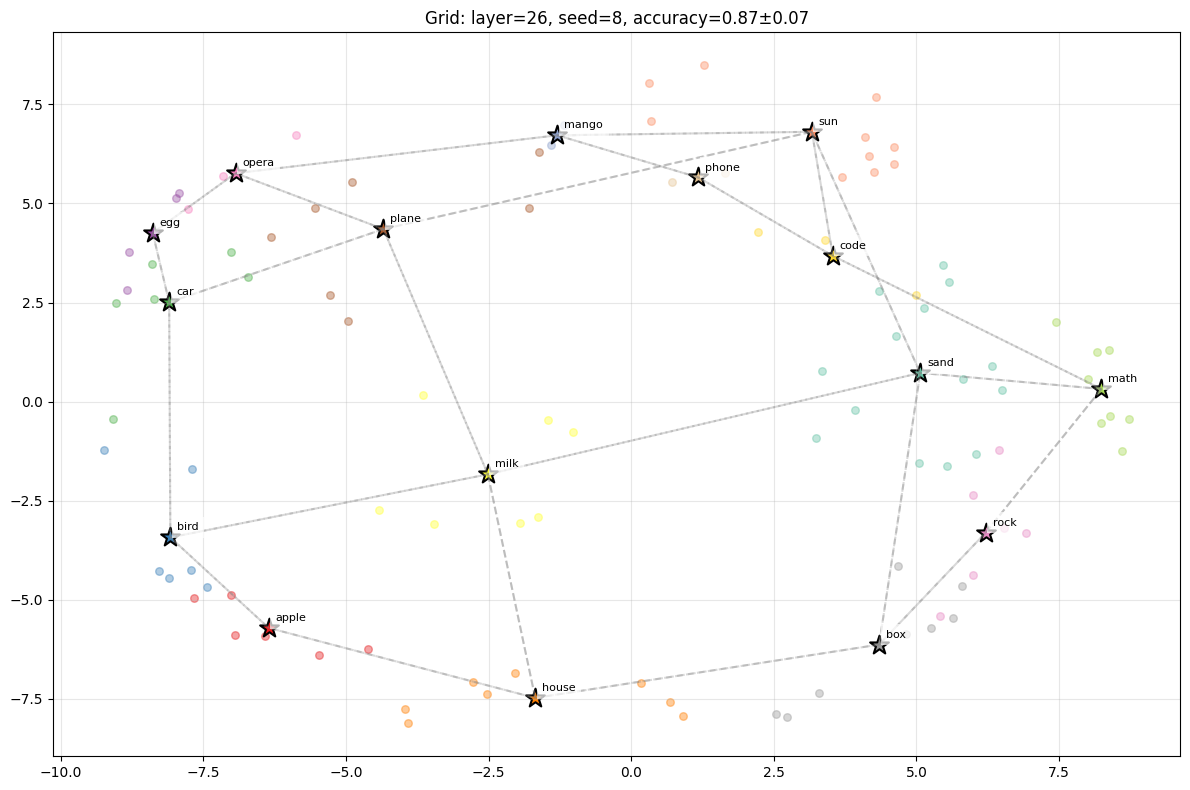

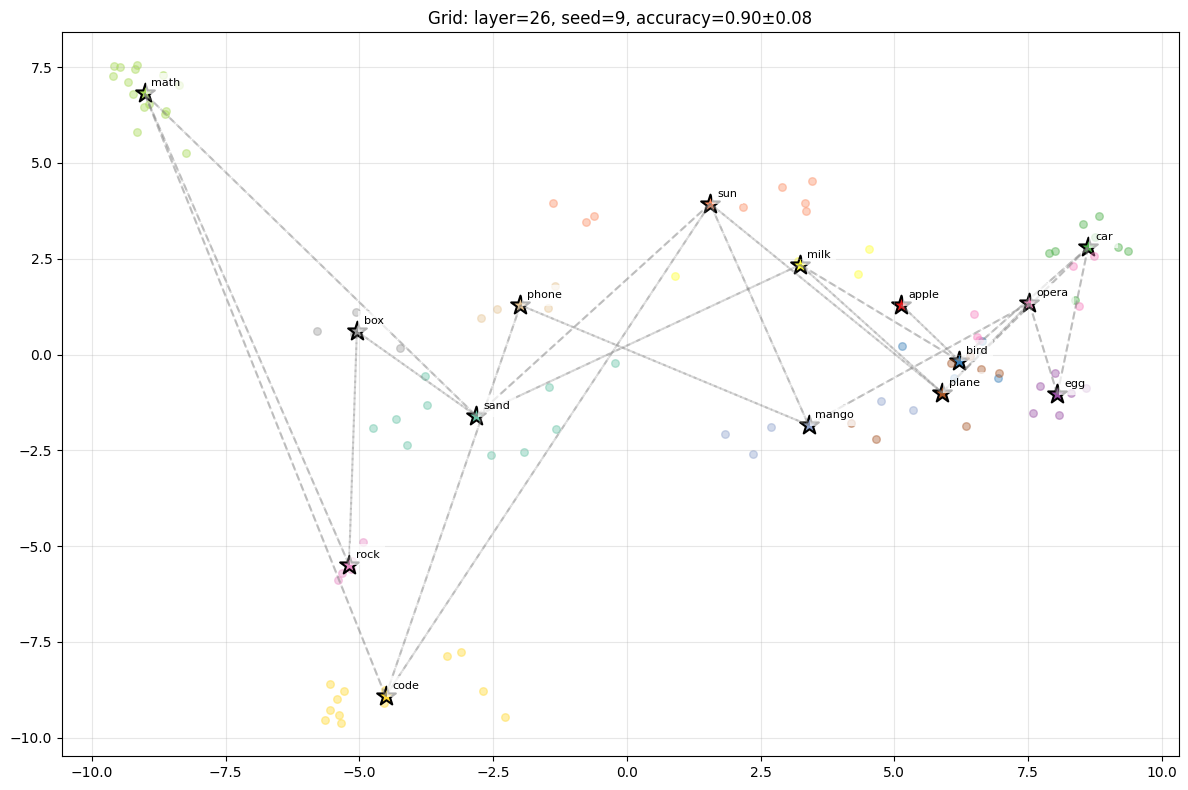

In [19]:
n_lookback = 100
# layers = [20, 22, 24, 26, 28, 30]
layers = [26]
for seed in range(10):
    set_seed(seed)

    sequence = grid.generate_sequence(1000)
    accuracies = np.array(get_model_accuracies(sequence))

    layer_to_acts = get_activations(sequence, n_lookback=n_lookback, layers=layers)
    layer_to_pca_directions = {layer: get_pca_directions(acts, top_n=2) for layer, acts in layer_to_acts.items()}

    accuracy_subtitle = f'accuracy={accuracies[-n_lookback:].mean():.2f}±{accuracies[-n_lookback:].std():.2f}'

    for layer in layers:
        visualize_pca(sequence, layer_to_acts[layer], layer_to_pca_directions[layer], n_lookback=n_lookback, plot_title=f'Grid: layer={layer}, seed={seed}, {accuracy_subtitle}')

Observation:
- Sometimes the graph is really pretty.
- But sometimes it's not.
- Depends on random seed.